# irisのデータをXGBoostで解析してみる。

In [1]:
import xgboost as xgb
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

## データセットの読み込み

In [2]:
iris = datasets.load_iris()

In [3]:
iris_df = pd.DataFrame(iris.data)
iris_df = iris_df.rename(columns={
    0: 'sepal_length',
    1: 'sepal_width',
    2: 'petal_length',
    3: 'petal_width'})
iris_df['target'] = iris.target
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## データセットを学習と評価用に分ける

In [4]:
train_df, test_df = model_selection.train_test_split(iris_df, test_size=0.3)

In [5]:
train_df_y = train_df[['target']]
train_df_x = train_df.copy().drop('target', axis=1)
test_df_y = test_df[['target']]
test_df_x = test_df.copy().drop('target', axis=1)

## ハイパーパラメータ探索しつつ学習する

In [6]:
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = model_selection.GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv.fit(train_df_x, [i[0] for i in train_df_y.values])
print(clf_cv.best_params_, clf_cv.best_score_)

# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(train_df_x, [i[0] for i in train_df_y.values])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 4, 'n_estimators': 50} 0.971428571429


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.4s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## 評価する

In [7]:
pred = clf.predict(test_df_x)
print(confusion_matrix([i[0] for i in test_df_y.values], pred))
print(classification_report([i[0] for i in test_df_y.values], pred))

[[19  0  0]
 [ 0 11  1]
 [ 0  2 12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       0.85      0.92      0.88        12
          2       0.92      0.86      0.89        14

avg / total       0.94      0.93      0.93        45



## 変数の重要度を可視化

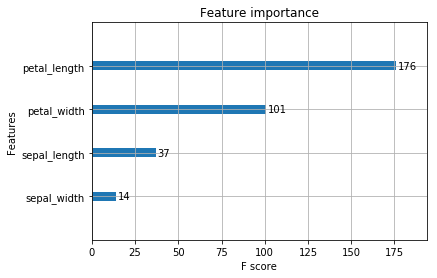

In [8]:
xgb.plot_importance(clf)
plt.show()

## 決定木のプロット(1例)

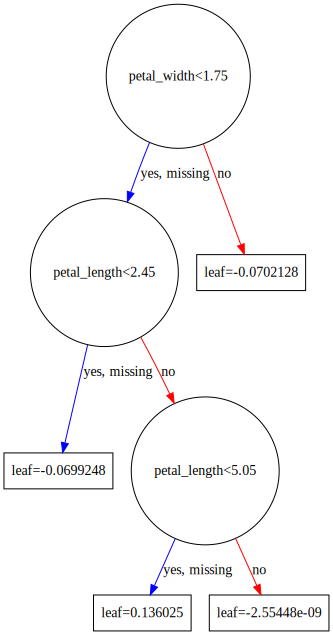

In [9]:
xgb.to_graphviz(clf, num_trees=1)